Name: Jonathan Park <br>
Date: 2022.04.03

# Project Shappify: Topic Modeling and Model Exploration Part 4
***

## Introduction

To uncover hidden themes or topics that are present throughout the corpus of the Shopify App Store reviews dataset, Latent Dirichlet Allocation (LDA) will be used. LDA is an unsupervising machine learning approach to identifying hidden topics.

The CountVectorizer parameters from part 3 will be used to guide the process of the data to be fitted.

For implementing the LDA, a series of tutorials and scripts were used for either adaptation, learning, and/or inspiration for the process in this notebook. The sources are as follows:

- Source 1: [Python Tutorials for Digital Humanities](https://www.youtube.com/watch?v=jwzD1nCN-4M&list=PL2VXyKi-KpYttggRATQVmgFcQst3z6OlX&index=9&ab_channel=PythonTutorialsforDigitalHumanities)
- Source 2: [Dashofdata Tutorials](https://www.youtube.com/watch?v=5BVebXXb2o4)
- Source 3: [Dashofdata GitHub](https://github.com/adashofdata/nlp-in-python-tutorial)
- Source 4: [pyLDAvis](https://github.com/bmabey/pyLDAvis)
- Source 5: [Python NLP Cookbook/Github](https://github.com/PacktPublishing/Python-Natural-Language-Processing-Cookbook)
- Source 6: [Topic Model Relevant Words Extraction Example](https://nicharuc.github.io/topic_modeling/)

<!-- Related to Source 6 (https://stackoverflow.com/questions/69492078/how-to-get-list-of-words-for-each-topic-for-a-specific-relevance-metric-value-l?rq=1) -->

### Import Packages

In [1]:
# Array and dataframe manipulation libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Visual progress bar library
from tqdm import tqdm
tqdm.pandas()

# Saving models
import pickle

# Gensim library for LDA
import gensim
from gensim import matutils, models
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora

# Sklearn library
from sklearn.feature_extraction.text import CountVectorizer

# Spare matrix library
import scipy.sparse

# Python LDA visualization tool
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Wordcloud library
from wordcloud import WordCloud, ImageColorGenerator

### Import Data

In [2]:
# # Import dataset
reviews_df_clean_3_en = pd.read_pickle('reviews_df_clean_3a_en_verb_only_lemmatized_part_2.pkl')

Reset the index of the dataframe. This is implemented for downstream analysis and compilation of dominant topics across reviews.

In [3]:
reviews_df_clean_3_en = reviews_df_clean_3_en.reset_index(drop = True)

Take a quick glimpse of the top and bottom 5 rows.

In [4]:
reviews_df_clean_3_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,great and super fast customer service highly c...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,still set up my store and after initially pay ...,NaN,NaT,1,en
2,Instant Search +,2020-08-04,this be an excellent search app which they hav...,NaN,NaT,1,en
3,Instant Search +,2020-07-30,a great great great customer service thanks to...,NaN,NaT,1,en
4,Instant Search +,2020-07-28,i be begginig to use this app the search engin...,NaN,NaT,1,en


In [5]:
reviews_df_clean_3_en.tail()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
427293,COD Order Confirmation,2018-03-22,very very well explain tutorial seem very easy...,NaN,NaT,1,en
427294,COD Order Confirmation,2018-01-23,finally we have an app for for cod confirmatio...,NaN,NaT,1,en
427295,COD Order Confirmation,2018-01-05,useful app help us to reduce cost time highly ...,NaN,NaT,1,en
427296,COD Order Confirmation,2017-06-15,do not purchase this application it be like sh...,NaN,NaT,0,en
427297,COD Order Confirmation,2016-01-06,​​a must​ have​ app for those have e stores wi...,NaN,NaT,1,en


In [6]:
reviews_df_clean_3_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427298 entries, 0 to 427297
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        427298 non-null  object        
 1   review_date     427298 non-null  datetime64[ns]
 2   review_text     427298 non-null  object        
 3   dev_reply_text  45305 non-null   object        
 4   dev_reply_date  45305 non-null   datetime64[ns]
 5   is_review_good  427298 non-null  int32         
 6   lang_iso        427298 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 21.2+ MB


### What is the distribution of positive and negative reviews?

Let's take a look at the proportion of positive and negative reviews from the final dataset.

In [7]:
reviews_df_clean_3_en['is_review_good'].value_counts(normalize = True)

1    0.930187
0    0.069813
Name: is_review_good, dtype: float64

The proportion of positive and negative reviews from Part 1 of the Jupyter notebooks revealed 93.03% positive reviews and 6.97% of negative reviews. The text normalized English-only reviews being used revealed the proportion of positive (93.01%) and negative (6.98%) reviews persisted despite all of the text-preprocessing steps.

Let's move on to the topic modeling.

# Topic Modeling - Latent Dirichlet Allocation

For successfully implementing topic modeling, three different inputs are required for the model. 

They are:

- Corpus
- Dictionary
- Term-Document Matrix

## Standard Data Formats

I will first define a function that uses the CountVectorizer to create a compressed sparse row (CSR) matrix of the Document-Term Matrix.

In [8]:
# Create a CountVectorizer function with specified parameters and fit/transform the data and
# output the corresponding matrix

# Create a CountVectorizer
cv = CountVectorizer(max_df=0.95, max_features=60_000, ngram_range=(1, 2))

# Save the compressed sparse row matrix (CSR) after fitting and transforming data
# with the CountVectorizer
csr_matrix = cv.fit_transform(reviews_df_clean_3_en['review_text'])

Check the size of the CSR matrix.

In [9]:
csr_matrix

<427298x60000 sparse matrix of type '<class 'numpy.int64'>'
	with 20507811 stored elements in Compressed Sparse Row format>

The input for the LDA model requires the CSR of the Document-Term Matrix to be a Term-Document Matrix (TDM). I will take the transpose of the CSR matrix to convert it into a TDM.

In [10]:
# Transpose the document-term matrix into term-document matrix
csr_matrix_transpose = csr_matrix.T

We can see it was successfully implemented by comparing the shapes and seeing the dimensions flipped.

In [11]:
csr_matrix_transpose

<60000x427298 sparse matrix of type '<class 'numpy.int64'>'
	with 20507811 stored elements in Compressed Sparse Column format>

The format of the CSR matrix will be converted into a gensim corpus using one of gensim's functions.

In [12]:
# Place the TDM into a gensim corpus format
corpus = matutils.Sparse2Corpus(csr_matrix_transpose)

Check the size of the CSR within the corpus object created.

In [13]:
corpus.sparse

<60000x427298 sparse matrix of type '<class 'numpy.int64'>'
	with 20507811 stored elements in Compressed Sparse Column format>

In order to successfully implement the LDA and pyLDAvis tool later in the notebook, a dictionary of the words and their location in the TDM are required with specific formats.

In [14]:
# Gensim also requires dictionary of all the terms and their respective location in the term-document matrix.
# pyLDAvis requires token2id within the dictionary input argument.
# The token2id was achieved with the help of stack overflow post below:
# https://stackoverflow.com/questions/59024220/error-in-computing-the-coherence-score-attributeerror-dict-object-has-no-at

# Convert the CountVectorizer's words/tokens and their respective indices in the 
# TDM matrix into a dictionary of words and their ids for LDA model input
# Adapted from Dashofdata tutorials
id2word = dict((v, k) for k, v in cv.vocabulary_.items()) 
word2id = dict((k, v) for k, v in cv.vocabulary_.items())

# Dictionaries for pyLDAvis tool input
# Adapted from https://radimrehurek.com/gensim/corpora/dictionary.html
dictionary = corpora.Dictionary()
dictionary.id2token = id2word
dictionary.token2id = word2id

Now that I have the corpus (Term-Document matrix) and id2word (Dictionary of Word and Location/Index), I will implement the LDA model.

## Topic Modeling - 5 Topics

A 5-topic model was created initially, as the literature had previously found 4-17 topics across app store reviews.

In [15]:
# # Implement the LDA model
# # https://radimrehurek.com/gensim/models/ldamodel.html for parameter defintions

# # Model took 48m to run
# # Model has been previously implemented below and commented out

# lda_model = models.LdaModel(corpus = corpus,
#                             id2word = id2word,
#                             num_topics = 5, # specify number of requested latent topics
#                             random_state = 1,
#                             update_every = 1, # number of docs/reviews to iterate through each update (batch vs. online learning)
#                             chunksize = 100, # number of docs/reviews to use in each training chunk
#                             passes = 10, # pass data 10 times
#                             alpha = 'auto')  # automatically dictate parameter for "how topics are distributed across the documents" https://msaxton.github.io/topic-model-best-practices/compare_alphas.html

In [16]:
# lda_model.print_topics()

### Save the Model

I will save the LDA model created.

In [17]:
# lda_model.save("lda_model_v1_5_topics.model")

Load the saved LDA model.

In [18]:
lda_model = gensim.models.ldamodel.LdaModel.load("lda_model_v1_5_topics.model")

### Visualize the LDA Model

Let's visualize the LDA topic model and analyze the results using Python LDA Visualization (pyLDAvis).

In [19]:
# Enable running of visualization inline
pyLDAvis.enable_notebook() 

# Details regarding the mds parameters and their meaning
# https://stackoverflow.com/questions/50923430/what-does-the-parameter-mds-mean-in-the-pyldavis-sklearn-prepare-function

# Input all the arguments made previously into the visualization tool 
vis = gensimvis.prepare(lda_model, 
                        corpus, 
                        dictionary, 
                        mds = "mmds", # dimensionality reduction through Jensen-Shannon Divergence and Metric Multidimensional Scaling
                        R = 30, # R = top X words for the topic to visualize on right-hand side
                        lambda_step = 0.1) # steps for modifying lamba weighting variable in visualization

C:\ProgramData\Anaconda3\envs\nlp_env\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [20]:
# Call the visualization
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.153666  0.191501       1        1  30.384900
0     -0.063675 -0.282746       2        1  23.213066
4     -0.340673 -0.073046       3        1  22.878156
2     -0.168018  0.341941       4        1  17.851810
1      0.418700 -0.177650       5        1   5.672067, topic_info=       Term           Freq          Total Category  logprob  loglift
51      you  156172.000000  156172.000000  Default  30.0000  30.0000
164      it  325167.000000  325167.000000  Default  29.0000  29.0000
0     great  164346.000000  164346.000000  Default  28.0000  28.0000
8       app  359794.000000  359794.000000  Default  27.0000  27.0000
11     easy  127820.000000  127820.000000  Default  26.0000  26.0000
...     ...            ...            ...      ...      ...      ...
398     lot    7707.570476   20343.458203   Topic5  -5.1554   1.8991
34      for   13671.371018  210998.463109   Topic5  -4.5823   0.1331
1185   keep    5856.040891   11203.558506   Topic5  -5.4301   2.2209
646    time    7045.387230   44828.626000   Topic5  -5.2452   1.0191
400     get    6420.175180   54634.282915   Topic5  -5.3381   0.7284

[294 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1997      1  0.999974     about
308       2  0.999985       add
31        1  0.920181     after
31        3  0.079794     after
57        1  0.237952       all
...     ...       ...       ...
1066      5  0.999864  you guys
5325      5  0.999763    you so
161       1  0.122324      your
161       2  0.815831      your
161       5  0.061851      your

[372 rows x 3 columns], R=30, lambda_step=0.1, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

Note that the topic numbers here are based on an indexing starting with 1, as opposed to Python's start with 0. This may be due to pyLDAvis having its' origin from first implemented in R prior to being implemented in Python.

Interpreting the pyLDAvis plot reveals the following information:

- Based on the intertopic distance map, these current 5 topics are quite distinct from one another.

With manipulation of the relevance parameter to 0.1, we can see the following information about the words within the topics:

- Topic 1
    - The most relevant terms reveal no discernible theme(s) or topic(s) except for stop words. Some stop words may be informative. For instance, "could" may be related to a feature request (e.g. "could you make...").
    
- Topic 2
    - The relevant terms reveal characteristics regarding features of a store (e.g., "store", "make", "add", "images", "product", "shipping", "my store" etc.). This topic may relate to the creation or implementation of some feature, as multiple occurrences of "to make", "to add", "way to", "my store", and "my site".
    
- Topic 3
    - With multiple occurrences of relevant terms, such as "support", "customer service" and "support team", this topic relates to the customer support team. Furthermore, with other occurrences of relevant terms, such as "fix", "issue", "problem", and "responsive", this topic also possibly relates to troubleshooting. Lastly, with relevant terms of "best" and "quickly", there may be positive sentiment related to the customer support team also integrated into this topic.
    
- Topic 4
    - The relevant terms reveal multiple variations and occurrences of "easy", "easy to", "to use", "very easy", indicating the topic relates to the ease of use of an application. In addition, there are multiple occurrences of "recommend", "recommend it", "highly recommend", "would recommend", suggesting the topic relates to the user community's stance on whether it recommends the app to other users. Furthermore, other positive sentiment words observed were: "nice", "love it", "good app", "useful", "friendly", and "simple", indicating positive praise for an application. Topic 4 is possibly related more to positive reviews than negative reviews.
   
- Topic 5
    - With most relevant terms revealing "thank", "thank you" and "help", this indicates an expression of gratitude possibly related to the help received. Furthermore, several occurrences referring to "set up", "to create", "save me", and "help me" indicates the topic related to the set up or creation of a feature and a request for help or assistance or troubleshooting; similar to topic 2.

With manipulation of the relevance parameter to 1.0, we can see the following information about the words within the topics:

- Topic 1
    - The most common terms reveal no discernible theme(s) or topic(s) except for stop words. However, some stop words are known to be informative stop words (e.g., "could", "should" and "must" can indicate feature request; "but", "before", "now", can reflect a bug report).
    
- Topic 2
    - Similarly, the most common terms reveal no discernible theme(s) or topic(s) except for stop words. However, further down the list, there are terms related to "make" and "store" and other characteristics related to one's commerce website.
    
- Topic 3
    - The most common terms appear to relate to "support" or "customer service".
    
- Topic 4
    - The most common terms appear to relate to praise of an app with words such as "easy", "great", "recommend", and so forth.
    
- Topic 5
    - The most common terms refer to "help", "thanks", and "set up".

# Data Visualization

## Word Cloud Creation

I will now create word clouds for the 30 most relevant tokens/features observed for each topic.

In [21]:
# The specific relevance metric value to use for extracting the relevant terms
lambd = 0.1

all_topics = {}
num_topics = lda_model.num_topics + 1
num_terms = 30

# Extract the 30 most relevant terms obtained from the LDA for each topic
# using the lambda parameter 0.1 (i.e., weighting more towards terms
# that were observed to have a higher proportion for a particular topic
# relative to the proportion observed in the overall corpus as opposed to
# magnitude of overall term frequency)
for i in range(1, num_topics):
    topic = vis.topic_info[vis.topic_info.Category == 'Topic' + str(i)].copy()
    
    topic['relevance'] = topic['loglift'] * (1 - lambd) + topic['logprob'] * lambd
    
    all_topics['Topic ' + str(i)] = topic.sort_values(by='relevance', 
                                                      ascending=False).Term[:num_terms].values

In [22]:
# Create a dataframe for the 30 most relevant words achieved with the LDA model
# for each of the topic
all_topics_relevant_words = pd.DataFrame(all_topics)

In [23]:
# Display the dataframe
all_topics_relevant_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,do,my,support,easy,help
1,not,store,we,easy to,thank
2,but,products,customer,to use,thank you
3,if,make,service,great,set
4,do not,add,customer service,very,much
5,what,printful,team,great app,up
6,will,customers,best,recommend,set up
7,just,site,the best,use and,help me
8,only,order,support be,very easy,for my
9,how,images,the support,use,so much


### Word Cloud - Topic 1

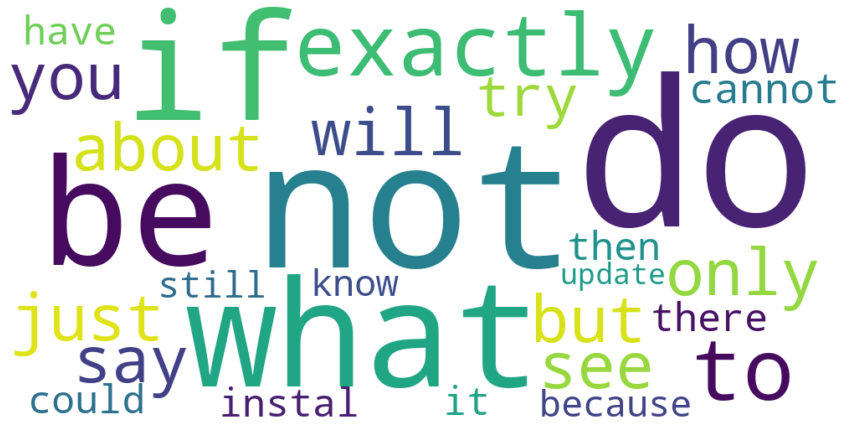

In [24]:
# Convert the relevant terms for a topic from a list into a string and generate
# the word cloud
unique_string=(" ").join(all_topics_relevant_words['Topic 1'].values)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white", stopwords= '',
                      collocations=True, prefer_horizontal = 1.0, random_state = 1).generate(unique_string)

# Plot the wordcloud figure
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save figure
# plt.savefig("topic_1_color.svg", bbox_inches='tight')

plt.show()
plt.close()

### Word Cloud - Topic 2

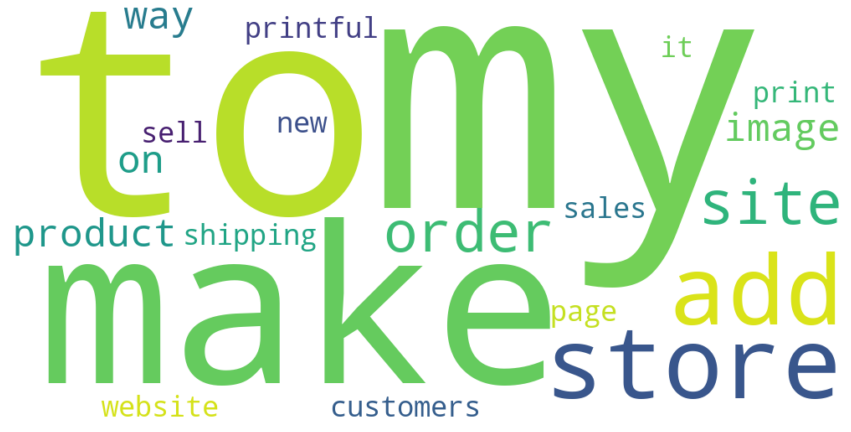

In [25]:
# Convert the relevant terms for a topic from a list into a string and generate
# the word cloud
unique_string=(" ").join(all_topics_relevant_words['Topic 2'].values)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white", stopwords= '',
                      collocations=True, prefer_horizontal = 1.0, random_state = 1).generate(unique_string)

# Plot the wordcloud figure
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save figure
# plt.savefig("topic_2_color.svg", bbox_inches='tight')
plt.show()
plt.close()

### Word Cloud - Topic 3

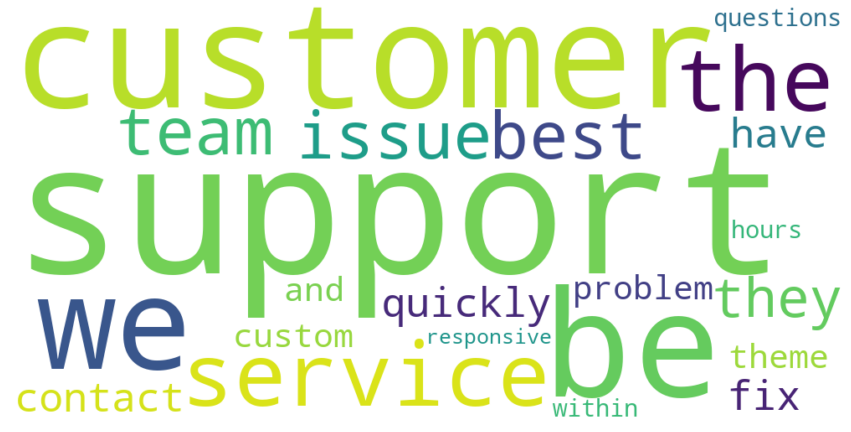

In [26]:
# Convert the relevant terms for a topic from a list into a string and generate
# the word cloud
unique_string=(" ").join(all_topics_relevant_words['Topic 3'].values)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white", stopwords= '',
                      collocations=True, prefer_horizontal = 1.0, random_state = 1).generate(unique_string)

# Plot the wordcloud figure
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save figure
# plt.savefig("topic_3_color.svg", bbox_inches='tight')
plt.show()
plt.close()

### Word Cloud - Topic 4

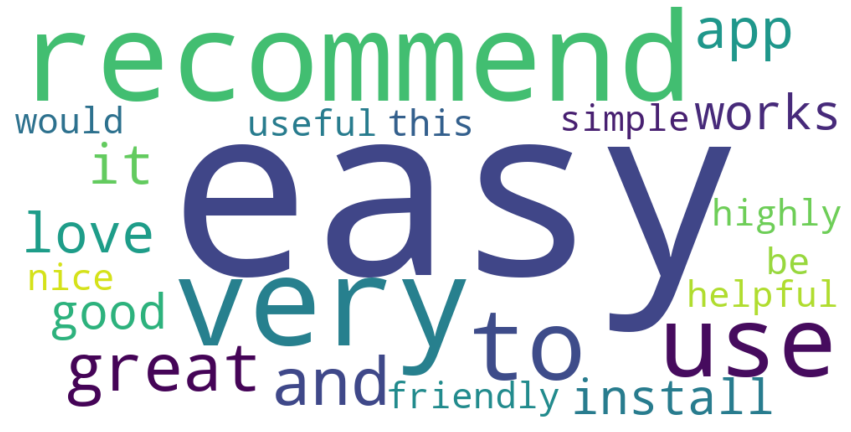

In [27]:
# Convert the relevant terms for a topic from a list into a string and generate
# the word cloud
unique_string=(" ").join(all_topics_relevant_words['Topic 4'].values)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white", stopwords= '',
                      collocations=True, prefer_horizontal = 1.0, random_state = 1).generate(unique_string)

# Plot the wordcloud figure
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save figure
# plt.savefig("topic_4_color.svg", bbox_inches='tight')
plt.show()
plt.close()

### Word Cloud - Topic 5

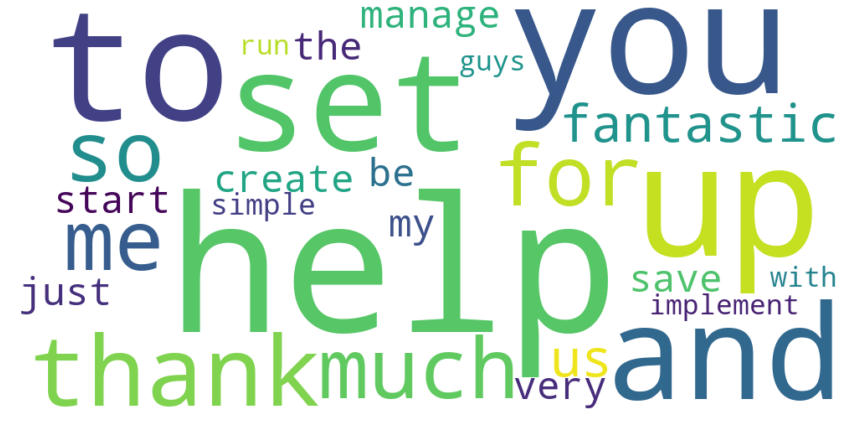

In [28]:
# Convert the relevant terms for a topic from a list into a string and generate
# the word cloud
unique_string=(" ").join(all_topics_relevant_words['Topic 5'].values)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white", stopwords= '',
                      collocations=True, prefer_horizontal = 1.0, random_state = 6).generate(unique_string)

# Plot the wordcloud figure
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save figure
# plt.savefig("topic_5_color.svg", bbox_inches='tight')
plt.show()
plt.close()

## Distribution of Topics in Positive and Negative Reviews

I will now compile the dominant topic in each review and compare the distribution of those topics between positive and negative reviews.

The topics that are retrieved from the LDA model is structured as an array with a list of tuples for each review that was evaluated. As a result, a custom sort function will be defined to sort the tuples in ascending order to then take the dominant topic for the review.

The sort function was adapted from the following sources:

- Source 1: [Python Tutorials for Digital Humanities](https://www.youtube.com/watch?v=xADAr8pPQMI&ab_channel=PythonTutorialsforDigitalHumanities)
- Source 2: [Geeksforgeeks URL](https://www.geeksforgeeks.org/python-sort-list-according-second-element-sublist/)

In [29]:
# Sort a list of tuples using the second element of the tuple
# and ordered in reverse to achieve descending order
def Sort(lda_topics):
  
    # Sort using second element of tuple from list of tuples
    lda_topics.sort(key = lambda x: x[1])
    
    # Sort in descending order
    lda_topics.reverse() 
    
    return lda_topics

### Positive Reviews and Dominant Topics

I will now filter out and separate the dataframe indices for the positive reviews.

In [30]:
positive_reviews_index = reviews_df_clean_3_en[reviews_df_clean_3_en['is_review_good'] == 1].index

I will now retrieve and compile all the dominant topics for each review that was positive.

In [31]:
top_positive_topics_v1 = []

for i in tqdm(positive_reviews_index):
    lda_topics_for_review = lda_model[corpus[i]]
    
    # Take the dominant topic after sorted
    top_positive_topics_v1.append(Sort(lda_topics_for_review)[0][0]) 

100%|██████████| 397467/397467 [01:33<00:00, 4245.39it/s]


Create the compilation of dominant topics into a dataframe.

In [32]:
top_positive_topics_v1_df = pd.DataFrame(top_positive_topics_v1)

Count the total for each topic observed, normalize the values and convert into percentage.

In [33]:
top_positive_topics = round(top_positive_topics_v1_df.value_counts(normalize = True).sort_index(), 2) * 100

In [34]:
top_positive_topics

0    20.0
1     1.0
2    30.0
3    27.0
4    22.0
dtype: float64

### Negative Reviews and Dominant Topics

I will now filter out and separate the dataframe indices for the negative reviews.

In [35]:
negative_reviews_index = reviews_df_clean_3_en[reviews_df_clean_3_en['is_review_good'] == 0].index

I will now retrieve and compile all the dominant topics for each review that was negative.

In [36]:
top_negative_topics_v1 = []

review_text = []

for i in tqdm(negative_reviews_index):
    lda_topics_for_review = lda_model[corpus[i]]
    
    # Take the dominant topic after sorted
    top_negative_topics_v1.append(Sort(lda_topics_for_review)[0][0])

100%|██████████| 29831/29831 [00:11<00:00, 2550.28it/s]


Create the compilation of dominant topics into a dataframe.

In [37]:
top_negative_topics_v1_df = pd.DataFrame(top_negative_topics_v1)

Count the total for each topic observed, normalize the values and convert into percentage.

In [38]:
top_negative_topics = round(top_negative_topics_v1_df.value_counts(normalize = True).sort_index(), 2) * 100

In [39]:
top_negative_topics

0    10.0
1     0.0
2     2.0
3    85.0
4     4.0
dtype: float64

### Plot Compilation of Dominant Topics for Positive and Negative Reviews

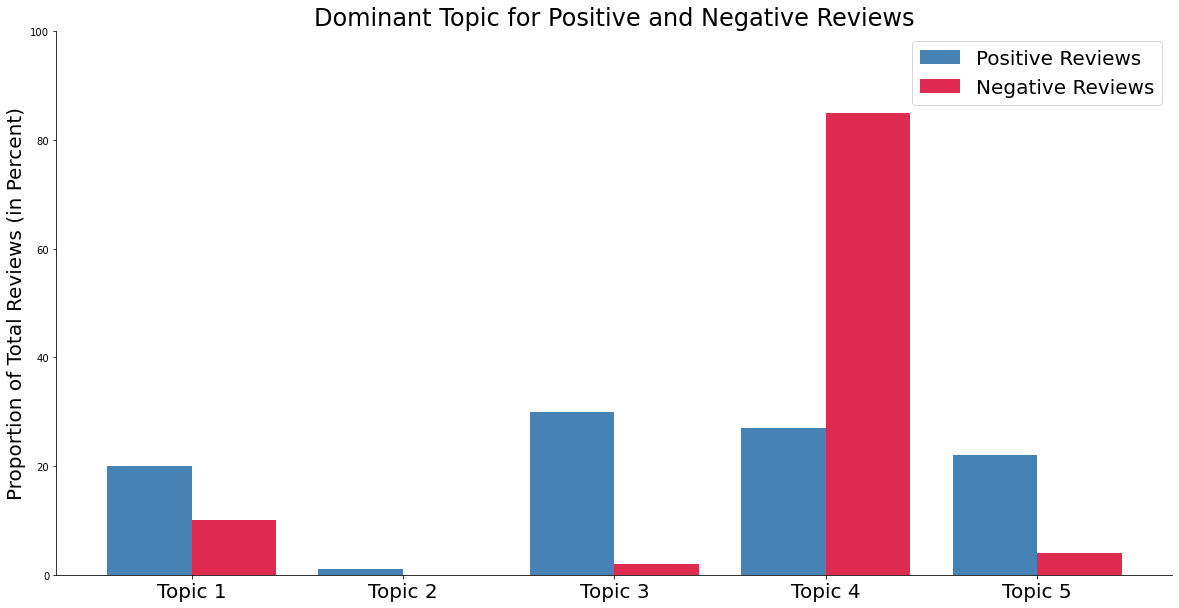

In [40]:
# Adapted from
# https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged

# Numbers of pairs of bars you want
N = 5

# Data on X-axis

# Specify the values of blue bars (height)
positive_topics = top_positive_topics.values
# Specify the values of red bars (height)
negative_topics = top_negative_topics.values

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(20,10))

# Width of a bar 
width = 0.4       

# Plotting
plt.bar(ind, positive_topics , width, label='Positive Reviews', color = "steelblue")
plt.bar(ind + width, negative_topics, width, label='Negative Reviews', color = "crimson", alpha = 0.9)

# plt.xlabel('Latent Topics from LDA', size = 24)
plt.ylabel('Proportion of Total Reviews (in Percent)', size = 20)
plt.title('Dominant Topic for Positive and Negative Reviews', size = 24)

# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'), size = 20)

# Set axes limits
plt.ylim(0, 100)

# Finding the best position for legends and putting it
plt.legend(loc='best', fontsize = 20)
sns.despine()

# plt.savefig("dominant_topics.svg", bbox_inches='tight')
plt.show()

Interestingly, $\approx$ 85% of negative reviews contained `Topic 4` as the dominant topic. Conversely, $\approx$ 27% of positive reviews contained 
`Topic 4` as the dominant topic as well. This is a surprising result, given that `Topic 4` was observed to contain many positive sentiment relevant terms within the topic, as it related to "Ease of Use", "App Praise", and "User Community Recommendation". For instance, many occurrences for relevant terms such as "recommend", "recommend it", "highly recommend", and "would recommend" was observed. However, referencing back to Part 3 of the Jupyter Notebooks and logistic regression modeling, "not recommend" was found to be the most predictive feature for negative reviews. As a result, many of the negative reviews not recommending an app fall under `Topic 4` of "User Community Recommendation".

# Summary

With a 5-topic LDA model, many hidden themes were uncovered from each latent topic. 

For instance, `Topic 1` may relate to "Feature Requests" and "Bug Reports", based on the most relevant and common terms within the topic. However, further analysis is required. For instance, no stop words were used in the CountVectorizer parameters. Previous studies have recommended care in stop words usage and caution of using default stop words lists, as informative stop words may be present and inadvertently removed (e.g., "could", "should" and "must" can indicate feature request; "but", "before", "now", can reflect a bug report).

`Topic 2` may relate to "Feature Implementation", based on multiple occurrences of "to make", "to add", "way to", "my store", and "my site".

`Topic 3` may relate to "Customer Support Team", "Troubleshooting", and "Support Team Praise", based on multiple occurrences of relevant terms, such as "support", "customer service", "support team", "fix", "issue", "problem", "responsive", "best" and "quickly".

`Topic 4` may relate to "Ease of Use", "App Praise", and "User Community Recommendation", based on multiple occurrences of relevant terms, such as "easy", "easy to", "to use", "very easy", "nice", "love it", "good app", "useful", "friendly", "simple, "recommend", "recommend it", "highly recommend", and "would recommend".

`Topic 5` may relate to "Gratitude", "Troubleshooting", and "Feature Implementation", based on multiple occurrences of "thank", "thank you", "help", "set up", "to create", "save me", and "help me".

`Topic 5` may overlap with `Topic 2`.

The topic modeling revealed potentially important topics that the Shopify App store reviews contain. For instance, `Topic 1`, `Topic 4`, and `Topic 5` may inform stakeholders responsible for the software applications on potential feature requests, troubleshooting issues, and even potential reasons for dispraise observed for an app. This information can be relayed to stakeholders in the form of a report or a interactive graphical user interface. Furthermore, these topics can also be useful for the user community. For instance, `Topic 4` indicates that the `Ease of Use` may be an important topic for users and whether the `User Community Recommendation` endorses using the app or not. These topics can be made visible on an app's webpage on the Shopify App store with tags. In addition, a graphical user interface can be integrated to allow users to filter reviews on an app's webpage with respect to a particular topic.

Taken altogether, sentiment analysis and topic modeling conducted on Shopify's App Store reviews showed that reviews can contain important hidden topics that can be used by both stakeholders and the user community. Furthermore, machine learning processes can automate the process of extracting reviews and corresponding topics that can assist stakeholders in collecting high-quality feedback for optimizing the overall user experience. This emphasizes the literature's previous finding on the importance of the communication channel that an app store enables. Furthermore, the app store has become an important two-way communication channel and a medium by which users/merchants can seek help or support. 

Future work requires collaboration with domain experts (e.g., app developers, project managers, digital marketers) to interpret and establish a robust classification system for reviews and preferred communication channel mode (e.g., interactive dashboard or weekly/daily review summaries).

Several sub-topics are observed to be present in each latent topic. With the model-centric mindset, LDA hyperparameter optimization and topic coherence can be explored for developing a stronger taxonomy of more interpretable topics. Future analyses can explore additional models for more than 5 topics, given that previous studies have shown that app store reviews can contain 4-17 different topics.  

Steps towards including a stratified train-test split data and comparing the proportions of topics from train and test splits may further validate the LDA model for future use. In addition, reviewing each review and ensuring whether the dominant topic observed for a review made sense is warranted. 